In [43]:
import pandas as pd

import numpy as np

import math

In [44]:
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_auc_score,roc_curve


## Multivariate Filter
from sklearn.feature_selection import mutual_info_classif


from sklearn.feature_selection import RFE


## Wrapper Filter 
from sklearn.feature_selection import SequentialFeatureSelector


import matplotlib.pyplot as plt



In [45]:
df=pd.read_csv('cleaned.csv')

## remove rows containing null values

df=df.replace(np.nan,None)
df=df[~df.isnull().all(1)]


x=df.iloc[:,:-1]

x_cols=x.columns

## for x select all columns except the last
X=df.iloc[:,:-1].to_numpy()






## for y select the last
y_df=df.iloc[:,-1]
y=df.iloc[:,-1].to_numpy()



In [46]:
df.head()

,finished_first_q1,finished_first_q2,dif_seconds_quali_first_second,dif_seconds_quali_second_third,dif_seconds_quali_third_fourth,dif_seconds_qualif_fourth_fifth,isAmericas,isAustralia,isEurope,is_reigning_constructor_champion,is_reigning_driver_champion,driverAge,hadRain,avg_temp,avg_humidity,avg_pressure,avg_wind_speed,constructorPositionPreRace,driverPositionPreRace,finishedFirst
0,0,1,0.141,0.366,0.609,0.024,0,0,0,0.0,0.0,8290,0,87.916667,35.291667,1012.550000,7.833333,1.0,1.0,0
1,1,1,0.116,0.076,0.564,0.162,0,1,0,0.0,0.0,8304,0,75.400000,49.168333,1009.616667,13.166667,4.0,4.0,0
2,0,0,1.346,0.116,0.125,0.087,0,0,0,0.0,0.0,12273,0,88.100000,67.860000,1007.600000,8.783333,5.0,10.0,0
3,0,0,0.250,0.105,0.010,0.056,0,0,0,0.0,0.0,8325,0,67.350000,73.275000,1016.266667,15.633333,3.0,3.0,0
4,1,1,0.106,0.728,0.108,0.054,0,0,1,0.0,0.0,12308,0,66.350000,61.245000,1006.733333,8.600000,3.0,8.0,1


In [47]:
## Check dataset to see if it's imabalanced

df['finishedFirst'].value_counts()

## Dataset is nearly balanced 


finishedFirst
1    151
0    142
Name: count, dtype: int64

In [48]:

## due to differences in data scale we will apply standard scaling.





## Scale only the continuous/d variables as the categorical variables do not need this

X_binary=X[:,[0,1,6,7,8,9,10,12]]

X_numeric=X[:,[2,3,4,5,11,13,14,15,16,17,18]]

scaler=StandardScaler()

scaler.fit(X_numeric)

X_discrete=X[:,[0,1,6,7,8,9,10,12,17,18]] 

X_continuous_scaled=scaler.transform(X_numeric)

X_binary_cols=x.columns[[0,1,6,7,8,9,10,12]].tolist()
X_numeric_cols=x.columns[[2,3,4,5,11,13,14,15,16,17,18]].tolist()



X_scaled=np.concatenate([X_numeric,X_binary],axis=1)


data_out=pd.DataFrame(X_scaled,columns=(X_numeric_cols+X_binary_cols))
data_out['finishedFirst']=y



def toStr(val):
    if val==1:
        return 'y'
    if val==0:
        return 'n'

data_out['finishedFirst']=data_out['finishedFirst'].apply(lambda x: toStr(x))




data_out.to_csv('dataset_scaled.csv',index=False)





from sklearn.model_selection import train_test_split


subset=df.sample(frac=.8,axis=0)

subset=subset.reset_index(drop=True)


numeric_features=subset.iloc[:,0:9] 

categorical_features=subset.iloc[:,9:-1]

target=subset.iloc[:,-1]

## Apply univariate filtering 

## we have 19 total features, 9 are numeric, 10 are categorical (binary)

## we will choose 9 features, 5 from categorical and 4 from numeric



### Univariate Filter
from sklearn.feature_selection import SelectKBest, f_regression, chi2 # f_regression for continuous, chi2 for 



chi2_selector = SelectKBest(chi2, k='all')  # Select all features initially to get their scores
chi2_selector.fit(categorical_features, target)
chi2_scores = chi2_selector.scores_

anova_selector = SelectKBest(f_regression, k='all')  # Using F-test for continuous features
anova_selector.fit(numeric_features, target)
anova_scores = anova_selector.scores_


all_feature_scores = pd.DataFrame({
    'Feature': np.concatenate([categorical_features.columns, numeric_features.columns]),
    'Score': np.concatenate([chi2_scores, anova_scores])
    })

all_feature_scores['Category']=['Categorical','Categorical','Categorical','Categorical',
                                'Categorical','Categorical','Categorical','Categorical',
                                'Categorical','Categorical','Numeric','Numeric',
                                'Numeric','Numeric','Numeric','Numeric','Numeric',
                                'Numeric','Numeric']


## We will select all features and later apply the 

k = 19
top_k_features = all_feature_scores.nlargest(k, 'Score')



X_categorical_features=all_feature_scores[all_feature_scores.Category == 'Categorical'].nlargest(5, 'Score')['Feature']
X_numeric_features=all_feature_scores[all_feature_scores.Category == 'Numeric'].nlargest(4, 'Score')['Feature']


top_x_cols=[]


for a_col in X_categorical_features.tolist():
    top_x_cols.append(a_col)

for a_col in X_numeric_features.tolist():
    top_x_cols.append(a_col)


X_kbest=df.loc[:,top_x_cols].to_numpy()



scalerKBest=StandardScaler()

scalerKBest.fit(X_kbest)


X_kbest_scaled=scalerKBest.transform(X_kbest)


# Multivariate Filter (Correlation feature selection wrapper in Weka

## output returned just 4 columns 8,10,12,17 so we select those

X_corr_fs_scaled=X_scaled[:,[8,10,12,17]]



## initialize a df to save our model results
model_results=pd.DataFrame()


X_lib={'all_features':X_scaled,'univariate_filter':X_kbest_scaled,'multivariate':X_corr_fs_scaled,'wrapper':X_scaled}



print(len(X_scaled))

print(top_x_cols)

293
['avg_wind_speed', 'driverPositionPreRace', 'is_reigning_constructor_champion', 'is_reigning_driver_champion', 'constructorPositionPreRace', 'finished_first_q2', 'finished_first_q1', 'dif_seconds_quali_first_second', 'dif_seconds_quali_third_fourth']


variables method: all_features
Grid Search
Cross Validation
variables method: univariate_filter
Grid Search
Cross Validation
variables method: multivariate
Grid Search
Cross Validation
variables method: wrapper
Grid Search
Cross Validation


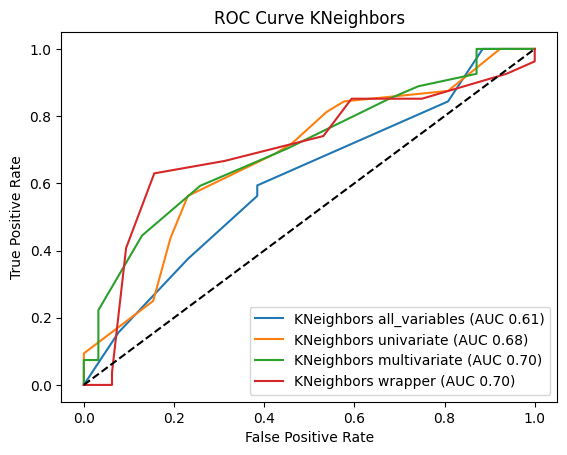

In [49]:
### K-Nearest Neighbors 
from sklearn.metrics import confusion_matrix







from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score




model=KNeighborsClassifier()

aucs_=[]
tprs_=[]
fprs_=[]


for a_set in X_lib.keys():

  


    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)
 

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 9 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    grid ={"n_neighbors":np.arange(1,20)}
    model= KNeighborsClassifier()


   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]

    aucs=[]
    tprs=[]
    fprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=KNeighborsClassifier(n_neighbors=gs_cv.best_params_['n_neighbors'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[0,1]
        fn=C[1,0]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

    

        counter+=1



    max_auc_idx=aucs.index(max(aucs))

    fprs_.append(fprs[max_auc_idx])
    tprs_.append(tprs[max_auc_idx])
    aucs_.append(aucs[max_auc_idx])







    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['K Means'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"KNeighbors "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve KNeighbors")
plt.legend(loc="best")
# plt.show()

plt.savefig('AUC_comparison_KNeighbors.png')


In [50]:
print(roc_auc_score(y_test,y_prob))

0.6742788461538463


variables method: all_features
Grid Search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
kernel: sigmoid
Cross Validation
variables method: univariate_filter


C:\Users\melli\AppData\Local\Temp\ipykernel_24852\2086115764.py:138: RuntimeWarning: invalid value encountered in scalar divide
  recall=tp/(tp+fn)
C:\Users\melli\AppData\Local\Temp\ipykernel_24852\2086115764.py:138: RuntimeWarning: invalid value encountered in scalar divide
  recall=tp/(tp+fn)
C:\Users\melli\AppData\Local\Temp\ipykernel_24852\2086115764.py:138: RuntimeWarning: invalid value encountered in scalar divide
  recall=tp/(tp+fn)


Grid Search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
kernel: sigmoid
Cross Validation
variables method: multivariate
Grid Search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
kernel: rbf
Cross Validation
variables method: wrapper
Grid Search
Fitting 5 folds for each of 36 candidates, totalling 180 fits
kernel: rbf
Cross Validation


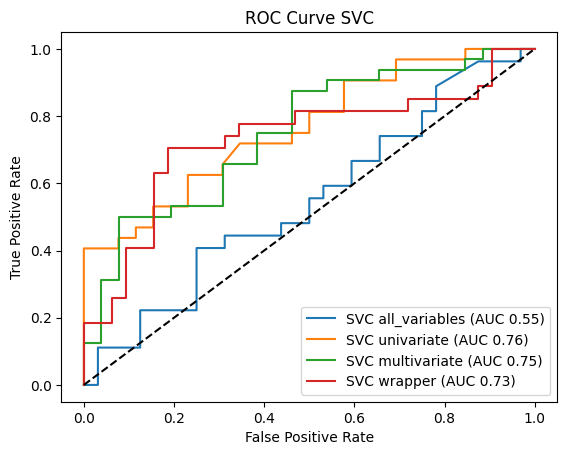

In [53]:
### SVC
from sklearn.metrics import confusion_matrix





from sklearn.model_selection import cross_val_score

from sklearn import svm




model=svm.SVC()

aucs_=[]
tprs_=[]
fprs_=[]



for a_set in X_lib.keys():

    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)


    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    if variables=='wrapper':
        
    
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


     ## use gridsearch 
    
    model= svm.SVC()



    grid ={"kernel":[ 'rbf','sigmoid' ],
        'C': [0.1, .2, .5, .7, 1, 2, 3, 4,5],
        'gamma': ['scale', 'auto']}
   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1,verbose=2) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    fprs=[]
    tprs=[]
    

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    print('kernel: '+gs_cv.best_params_['kernel'])
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=svm.SVC(probability=True,C=gs_cv.best_params_['C'],kernel=gs_cv.best_params_['kernel'],gamma=gs_cv.best_params_['gamma'])

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[0,1]
        fn=C[1,0]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 

        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

        

        counter+=1


    max_auc_idx=aucs.index(max(aucs))

    fprs_.append(fprs[max_auc_idx])
    tprs_.append(tprs[max_auc_idx])
    aucs_.append(aucs[max_auc_idx])

    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['SVC'],
                                'variable_method':[variables],
                                'hyper_parameters':[gs_cv.best_params_],
                                'cv_min_accuracy':[kfold_min_accuracy],
                                'cv_max_accuracy':[kfold_min_accuracy],
                                'cv_mean_accuracy':[kfold_min_accuracy],
                                'cv_min_recall':[kfold_min_recall],
                                'cv_max_recall':[kfold_max_recall],
                                'cv_mean_recall':[kfold_mean_recall],                   
                                'cv_min_precision':[kfold_min_precision],
                                'cv_max_precision':[kfold_max_precision],
                                'cv_mean_precision':[kfold_mean_precision],
                                'cv_min_f1':[kfold_min_f1],
                                'cv_max_f1':[kfold_max_f1],
                                'cv_mean_f1':[kfold_mean_f1],
                                'cv_mean_tps':[kfold_mean_tps],
                                'cv_mean_tns':[kfold_mean_tns],
                                'cv_mean_fps':[kfold_mean_fps],
                                'cv_mean_fns':[kfold_mean_fns],
                                'cv_mean_auc':[kfold_mean_auc],
                                'cv_min_auc':[kfold_min_auc],
                                'cv_max_auc':[kfold_max_auc]
                                })
    model_results=pd.concat([model_results,temp_results])



## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"SVC "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve SVC")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_SVC.png')




variables method: all_features
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2940 fits failed out of a total of 26460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2940 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: univariate_filter
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2940 fits failed out of a total of 26460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2940 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: multivariate
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2940 fits failed out of a total of 26460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2940 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation
variables method: wrapper
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2940 fits failed out of a total of 26460.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2940 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

Cross Validation


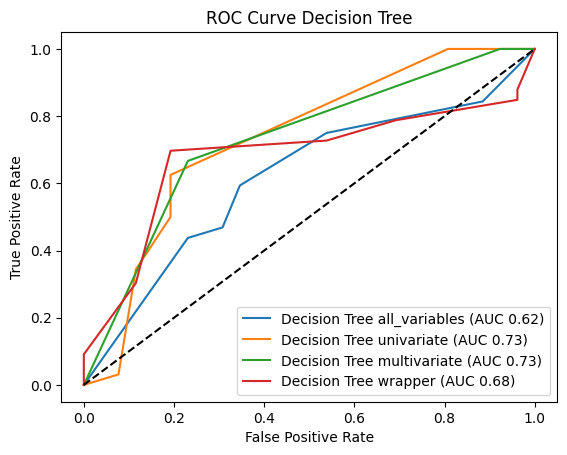

In [54]:
### Decision Tree
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier





from sklearn.model_selection import cross_val_score

aucs_=[]
tprs_=[]
fprs_=[]

model=DecisionTreeClassifier()

for a_set in X_lib.keys():

    X_vars=X_lib[a_set]

    variables=a_set

    print('variables method: '+variables)

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    

    if variables=='wrapper':
        
    
        # Apply Forward Selection with 8 variables
        selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        selected_mask = selector.get_support()

        # Get the indices of the selected features
        selected_indices = [i for i, x in enumerate(selected_mask) if x]


        X_vars=X_vars[:,selected_indices]

        # print(np.shape(X_vars))
    
   
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)


    ## use gridsearch 
    
    model= DecisionTreeClassifier()

    grid ={"criterion":['gini', 'entropy', 'log_loss' ],
            'max_features': np.arange(1,15),
            'max_depth': np.arange(1,15),
            'min_samples_split':np.arange(1,10)
            }
   
    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    fprs=[]
    tprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter
   
    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        # print('Fold #'+str(counter))
        
        model=DecisionTreeClassifier(criterion=gs_cv.best_params_['criterion'],
                                     max_features=gs_cv.best_params_['max_features'],
                                     max_depth=gs_cv.best_params_['max_depth'],
                                     min_samples_split=gs_cv.best_params_['min_samples_split']
                                     )

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[0,1]
        fn=C[1,0]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

  

        counter+=1


    max_auc_idx=aucs.index(max(aucs))

    fprs_.append(fprs[max_auc_idx])
    tprs_.append(tprs[max_auc_idx])
    aucs_.append(aucs[max_auc_idx])



    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['Decision Tree'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])


## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Decision Tree "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Decision Tree")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_Decision_Tree.png')




variables method: all_features
<class 'scikeras.wrappers.KerasClassifier'>
Grid Search


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/10


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4358 - loss: 0.7236
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5007 - loss: 0.6936
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5498 - loss: 0.6917
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5193 - loss: 0.6939
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4229 - loss: 0.7017
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6095 - loss: 0.6725
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4744 - loss: 0.6964
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5845 - loss: 0.6866
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5236 - loss: 0.6942
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4931 - loss: 0.6998
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #2
<class 'scikeras.wrappers.KerasClassifier

C:\Users\melli\AppData\Local\Temp\ipykernel_24852\1895860978.py:184: RuntimeWarning: invalid value encountered in scalar divide
  recall=tp/(tp+fn)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5119 - loss: 0.7147
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5457 - loss: 0.6906
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5437 - loss: 0.6936
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4579 - loss: 0.6963
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4901 - loss: 0.6963
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5116 - loss: 0.6944
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4568 - loss: 0.6955
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4955 - loss: 0.6956
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3916 - loss: 0.6991
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5406 - loss: 0.6919
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
Fold #3
<class 'scikeras.wrappers.KerasClassifie

C:\Users\melli\AppData\Local\Temp\ipykernel_24852\1895860978.py:184: RuntimeWarning: invalid value encountered in scalar divide
  recall=tp/(tp+fn)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4647 - loss: 0.8873
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5153 - loss: 0.7024
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4973 - loss: 0.6966
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5155 - loss: 0.6956
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5325 - loss: 0.6961
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4836 - loss: 0.6942
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5170 - loss: 0.6967
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4517 - loss: 0.6965
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4722 - loss: 0.6971
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5098 - loss: 0.6934
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step
Fold #4
<class 'scikeras.wrappers.KerasClassifier

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4582 - loss: 0.8096
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4930 - loss: 0.6949
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5392 - loss: 0.6926
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4940 - loss: 0.6959
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5480 - loss: 0.6908
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5224 - loss: 0.6952
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5263 - loss: 0.6935
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4358 - loss: 0.6982
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4505 - loss: 0.7023 
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5404 - loss: 0.6936
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold #5
<class 'scikeras.wrappers.KerasClassifie

C:\Users\melli\AppData\Local\Temp\ipykernel_24852\1895860978.py:184: RuntimeWarning: invalid value encountered in scalar divide
  recall=tp/(tp+fn)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5033 - loss: 0.6988
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5274 - loss: 0.6932
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4518 - loss: 0.6976
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4763 - loss: 0.6967 
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5043 - loss: 0.6974
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3962 - loss: 0.6979
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4715 - loss: 0.6950
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5278 - loss: 0.6925
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4917 - loss: 0.6953
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4171 - loss: 0.6965
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
variables method: univariate_filter
<class 'scik

C:\Users\melli\AppData\Local\Temp\ipykernel_24852\1895860978.py:184: RuntimeWarning: invalid value encountered in scalar divide
  recall=tp/(tp+fn)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/50


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4522 - loss: 0.7141  
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6149 - loss: 0.6633 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7176 - loss: 0.6310 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6863 - loss: 0.6101 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6683 - loss: 0.6343 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6909 - loss: 0.5995 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6868 - loss: 0.5913 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6902 - loss: 0.5816 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7010 - loss: 0.5914 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7173 - loss: 0.5729 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6857 - loss: 0.5951 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7136 - loss: 0.5938 
Epoch 13/50

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5010 - loss: 0.6885  
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7191 - loss: 0.6391 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6760 - loss: 0.6531 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6466 - loss: 0.6508 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7128 - loss: 0.6145 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6966 - loss: 0.6146 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6980 - loss: 0.6139 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6898 - loss: 0.6014 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7095 - loss: 0.5885 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6942 - loss: 0.6048 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6736 - loss: 0.6122 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6892 - loss: 0.5851 
Epoch 13/50

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6072 - loss: 0.6766  
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6126 - loss: 0.6603 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6670 - loss: 0.6459 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 0.6399 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6804 - loss: 0.6233 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6410 - loss: 0.6388 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6573 - loss: 0.6443 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6584 - loss: 0.6383 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6646 - loss: 0.6157 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6682 - loss: 0.6123 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6409 - loss: 0.6130 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6556 - loss: 0.6153 
Epoch 13/50

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5259 - loss: 0.6936
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6127 - loss: 0.6555 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6681 - loss: 0.6339 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6512 - loss: 0.6186 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6594 - loss: 0.6242 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7167 - loss: 0.5877 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6731 - loss: 0.6137 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6572 - loss: 0.6269 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6835 - loss: 0.5990 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7296 - loss: 0.5790 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7014 - loss: 0.5979 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7076 - loss: 0.5636 
Epoch 13/50
8

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4844 - loss: 0.6997  
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6081 - loss: 0.6630 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6341 - loss: 0.6589 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6152 - loss: 0.6388 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6439 - loss: 0.6423 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6557 - loss: 0.6375 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6469 - loss: 0.6221 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6543 - loss: 0.6291 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6712 - loss: 0.6238 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6547 - loss: 0.6184 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6797 - loss: 0.5901 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6603 - loss: 0.6268 
Epoch 13/50

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/50


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5236 - loss: 0.6972  
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5921 - loss: 0.6505 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5922 - loss: 0.6694 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6854 - loss: 0.6375 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6413 - loss: 0.6308 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6395 - loss: 0.6546 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - loss: 0.6395 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6100 - loss: 0.6560 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6597 - loss: 0.6421 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.6274 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6323 - loss: 0.6403 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6652 - l

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5367 - loss: 0.7123  
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6578 - loss: 0.6675 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5989 - loss: 0.6727 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6440 - loss: 0.6568 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6111 - loss: 0.6716 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6093 - loss: 0.6581 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6058 - loss: 0.6691 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5945 - loss: 0.6744 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6138 - loss: 0.6542 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6878 - loss: 0.6194 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6088 - loss: 0.6531 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6404 - l

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4995 - loss: 0.6970  
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5213 - loss: 0.6930 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4879 - loss: 0.6906 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5346 - loss: 0.6846 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5309 - loss: 0.6875 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5858 - loss: 0.6819 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5455 - loss: 0.6863 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5061 - loss: 0.6878 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6061 - loss: 0.6765 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5357 - loss: 0.6829 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5709 - loss: 0.6599 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5428 - l

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5242 - loss: 0.6974  
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5711 - loss: 0.6845 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5348 - loss: 0.6724 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6053 - loss: 0.6626 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6104 - loss: 0.6783 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5776 - loss: 0.6776 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5094 - loss: 0.6864 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6092 - loss: 0.6566 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5507 - loss: 0.6674 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5540 - loss: 0.6752 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6031 - loss: 0.6647 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5485 - l

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5043 - loss: 0.7003  
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5124 - loss: 0.6946 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5077 - loss: 0.6961 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5513 - loss: 0.6882 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5604 - loss: 0.6874 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4790 - loss: 0.6968 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5739 - loss: 0.6893 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5362 - loss: 0.6901 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5784 - loss: 0.6880 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5573 - loss: 0.6852 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5751 - loss: 0.6817 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5237 - l

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross Validation
Fold #1
<class 'scikeras.wrappers.KerasClassifier'>
Epoch 1/100


c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4809 - loss: 0.7245
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5659 - loss: 0.6901
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5932 - loss: 0.6715
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6026 - loss: 0.6775
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5264 - loss: 0.6720
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6126 - loss: 0.6637
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6189 - loss: 0.6595
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6222 - loss: 0.6623
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6267 - loss: 0.6509
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6036 - loss: 0.6639
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5780 - loss: 0.6653
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6710 - lo

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5498 - loss: 0.7000 
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5428 - loss: 0.6844
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5956 - loss: 0.6648
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6104 - loss: 0.6656
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5900 - loss: 0.6629
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6284 - loss: 0.6398
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6493 - loss: 0.6166
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6346 - loss: 0.6611
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6424 - loss: 0.6200
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6815 - loss: 0.6271
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: 0.6415
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7052 - l

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4912 - loss: 0.7053 
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5500 - loss: 0.6886
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5544 - loss: 0.6931
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5462 - loss: 0.6839
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5930 - loss: 0.6577
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5600 - loss: 0.6755
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5740 - loss: 0.6790
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5923 - loss: 0.6666
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5949 - loss: 0.6772
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5814 - loss: 0.6663
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5472 - loss: 0.6739
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5658 - l

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5796 - loss: 0.6925
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5416 - loss: 0.6915
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5368 - loss: 0.6883
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5363 - loss: 0.6888
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5083 - loss: 0.6926
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5208 - loss: 0.6943
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5885 - loss: 0.6782
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5002 - loss: 0.6898
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5179 - loss: 0.6886
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5257 - loss: 0.6940
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4844 - loss: 0.6793
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4505 - lo

c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\melli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5457 - loss: 0.6967
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5771 - loss: 0.6746
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5769 - loss: 0.6665
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5131 - loss: 0.6713
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5592 - loss: 0.6634
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6121 - loss: 0.6810
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6266 - loss: 0.6850
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6459 - loss: 0.6653
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6409 - loss: 0.6661
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6645 - loss: 0.6457
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5774 - loss: 0.6712
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5783 - lo

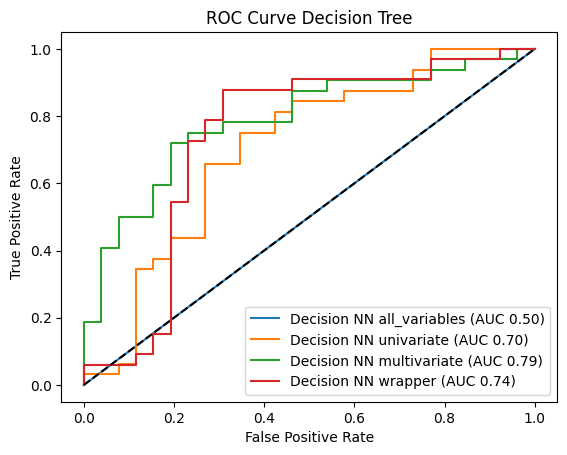

In [55]:
### Neural Network
from sklearn.metrics import confusion_matrix


from scikeras.wrappers import KerasClassifier



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split




aucs_=[]
tprs_=[]
fprs_=[]

model = Sequential()

def createModel(n_of_variables,buildKeras):
    powers_of_two=[16,32,64]

    a_model=Sequential()
    a_model.add(Dense(units=n_of_variables, activation='relu', input_dim=n_of_variables))

    a_model.add(Dense(units=powers_of_two[2], activation='relu'))

    a_model.add(Dense(units=powers_of_two[1], activation='tanh'))

    a_model.add(Dense(units=1, activation='sigmoid'))

    a_model.compile(
                loss='binary_crossentropy',
                metrics=['accuracy']
                )
    
    if buildKeras:
        a_model=KerasClassifier(model=a_model)
    
    return a_model


from sklearn.model_selection import cross_val_score



for a_set in X_lib.keys():


    X_vars=X_lib[a_set]

    n_vars=X_vars.shape[1]

    variables=a_set

    print('variables method: '+variables)


    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    
    model=createModel(n_vars,buildKeras=True)

    print(type(model))

    if variables=='wrapper':
        

        ## Weka code using wrapper on MultiLayerPerceptron w greedy stepwise returns variables with index 1,7,9,10

        X_vars=X_vars[:,[8,12,14,16]]

        # # Apply Forward Selection
        # selector = SequentialFeatureSelector(estimator=model, n_features_to_select=7, direction='forward')

        # selector.fit(X_train, y_train)

        # Get the boolean mask of the selected features
        # selected_mask = sffs.get_support()

        # Get the indices of the selected features
        # selected_indices = [i for i, x in enumerate(selected_mask) if x]


        # X_vars=X_vars[:,selected_indices]
        
        n_vars=X_vars.shape[1]

        # print(np.shape(X_vars))
    

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size=0.20)

    
    ## use gridsearch 
    
    optimizers = [Adam(learning_rate=.001),Adam(learning_rate=.01)]
    # optimizers = ['SGD', 'RMSprop',  'Adam',  'Nadam']
    epoch_options = [10, 50, 100,200,300]
    batch_sizes=[4,16,32,64]
    verbosity=[0]

    model=createModel(n_vars,buildKeras=True)
    
    grid=dict(optimizer=optimizers,epochs=epoch_options,batch_size=batch_sizes,verbose=verbosity)


    ## Implement Grid Search
    from sklearn.model_selection import GridSearchCV


    gs_cv=GridSearchCV(model,grid,cv=5,n_jobs=-1) #GridSearchCV
    print('Grid Search')
    gs_cv.fit(X_train,y_train)
    # print("tuned hyperparameter K:",gs_cv.best_params_)


    ## use KFold CV as well using the GridSearch Parameters
    from sklearn.model_selection import KFold
    scores=[]
    precisions=[]
    recalls=[]
    f1s=[]

    tps=[]
    tns=[]
    fps=[]
    fns=[]
    aucs=[]

    tprs=[]
    fprs=[]

    kFold=KFold(n_splits=5,shuffle=False)

    # use best gridsearch parameter

    counter=1
    print('Cross Validation')
    for train_index,test_index in kFold.split(X_vars):
        print('Fold #'+str(counter))
        
        model=KerasClassifier(build_fn=createModel(n_vars,buildKeras=False),optimizer=gs_cv.best_params_['optimizer'],
                                    epochs=gs_cv.best_params_['epochs'],
                                    batch_size=gs_cv.best_params_['batch_size'],
                                    )
        print(type(model))

        X_train, X_test, y_train, y_test = X_vars[train_index], X_vars[test_index], y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))

        preds=model.predict(X_test)

        C=confusion_matrix(y_test, preds)

        # print(C)


        tp=C[0,0]
        tn=C[1,1]

        fp=C[0,1]
        fn=C[1,0]

        tps.append(tp)
        tns.append(tn)
        
        fps.append(fp)
        fns.append(fn)

        precision=tp/(tp+fp)

        precisions.append(precision)

        recall=tp/(tp+fn)

        recalls.append(recall)



        f1=2*tp/((2*tp)+fp+fn)

        f1s.append(f1)

        y_prob=model.predict_proba(X_test)

        y_prob=y_prob[:,-1]

        auc=roc_auc_score(y_test,y_prob).mean()

        aucs.append(auc) 
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)

        fprs.append(fpr)
        tprs.append(tpr)

        counter+=1


    max_auc_idx=aucs.index(max(aucs))

    fprs_.append(fprs[max_auc_idx])
    tprs_.append(tprs[max_auc_idx])
    aucs_.append(aucs[max_auc_idx])



    # print(precisions)
    # print(recalls)
    # print(f1s)
    # print(tps)

    kfold_mean_precision=np.mean(precisions)
    kfold_mean_recall=np.mean(recalls)
    kfold_mean_f1=np.mean(f1s)

    kfold_min_precision=np.min(precisions)
    kfold_min_recall=np.max(recalls)
    kfold_min_f1=np.min(f1s)

    kfold_max_precision=np.max(precisions)
    kfold_max_recall=np.max(recalls)
    kfold_max_f1=np.max(f1s)

    
    kfold_mean_tps=np.mean(tps)
    kfold_mean_tns=np.mean(tns)
    kfold_mean_fps=np.mean(fps)
    kfold_mean_fns=np.mean(fns)


    kfold_mean_accuracy=np.mean(scores)
    kfold_min_accuracy=np.min(scores)
    kfold_max_accuracy=np.max(scores)

    kfold_min_auc=np.min(aucs)
    kfold_mean_auc=np.mean(aucs)
    kfold_max_auc=np.max(aucs)



    temp_results=pd.DataFrame({'algorithm':['NN'],
                               'variable_method':[variables],
                               'hyper_parameters':[gs_cv.best_params_],
                               'cv_min_accuracy':[kfold_min_accuracy],
                               'cv_max_accuracy':[kfold_min_accuracy],
                               'cv_mean_accuracy':[kfold_min_accuracy],
                               'cv_min_recall':[kfold_min_recall],
                               'cv_max_recall':[kfold_max_recall],
                               'cv_mean_recall':[kfold_mean_recall],                   
                               'cv_min_precision':[kfold_min_precision],
                               'cv_max_precision':[kfold_max_precision],
                               'cv_mean_precision':[kfold_mean_precision],
                               'cv_min_f1':[kfold_min_f1],
                               'cv_max_f1':[kfold_max_f1],
                               'cv_mean_f1':[kfold_mean_f1],
                               'cv_mean_tps':[kfold_mean_tps],
                               'cv_mean_tns':[kfold_mean_tns],
                               'cv_mean_fps':[kfold_mean_fps],
                               'cv_mean_fns':[kfold_mean_fns],
                               'cv_mean_auc':[kfold_mean_auc],
                               'cv_min_auc':[kfold_min_auc],
                               'cv_max_auc':[kfold_max_auc]
                               })
    model_results=pd.concat([model_results,temp_results])




## Plot AUC best with each method
plt.figure()



methods=['all_variables','univariate','multivariate','wrapper']

for idx in range(0,len(X_lib.keys())):
    cur_method=methods[idx]
    plt.plot(fprs_[idx], tprs_[idx], label=f"Decision NN "+cur_method+f" (AUC {aucs_[idx]:.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Decision Tree")
plt.legend(loc="best")
# plt.show()


plt.savefig('AUC_comparison_NN.png')

    



In [39]:
### Rule Induction

# import weka.core.jvm as jvm

# import os
# os.environ["JAVA_HOME"] ='C:/Users/melli/Downloads/openrefine-win-with-java-3.8.2/openrefine-3.8.2/server/target/jre/bin/client'

# print(jvm.started)

# if not jvm.started:
#     jvm.start()

# from weka.classifiers import Classifier
# from weka.core.converters import Loader




# # Load the dataset (ARFF or CSV format)
# loader = Loader(classname="weka.core.converters.ArffLoader")  # Use CSVLoader if CSV
# data = loader.load_file("dataset_scaled.arff")
# data.class_is_last()  # Specify the class attribute

# # Build the PART classifier
# part = Classifier(classname="weka.classifiers.rules.PART")
# part.build_classifier(data)



# jvm.stop()




In [56]:
model_results.to_csv('model_results.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt



samp_aucs=[.65]